# $^{83m}Kr$ LCE Maps: Xerawdp vs. Pax
_Ted Berger, Dan Alexander; June 17 2016_

In [1]:
from xerawdp_helpers import *    # helper functions for retrieving xerawdp data
from Kr83m_Basic import *        # pax minitree class for Kr83m data
from cut_helpers import *        # functions to apply and plot some event selections
from lce_helpers import *        # functions for binning, building map files, and plotting LCE maps

import numpy as np
import pandas as pd
import glob

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rc('font', size=16)

import hax
hax.init(main_data_paths=['/home/berget2/scratch-midway/paxProcessed_kr83mDiffusion'])

#hax.ipython.code_hider()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Table of Contents
[1 - Introduction](#introduction)  
[2 - Data and Event Selection](#data_and_selection)  
[3 - LCE Maps](#lce_maps)  
[4 - Next Steps: Xenon1T](#next_steps)  
[5 - References](#references) 

<a id='introduction'></a>
# Introduction

As an internal calibration, $^{83m}Kr$ proves very useful in a variety of liquid noble detectors. We utilize a solution of $^{83}Rb$ evaporated onto zeolite beads to generate $^{83m}Kr$ with a half-life of $86.2\ days$. From there, $^{83m}Kr$, with a half-life of $1.83\ hr$, generates a $32.1\ keV$ conversion electron or gamma with an internal conversion coefficient of $\alpha=2035$. This is then followed by a $9.4\ keV$ conversion electron or gamma with an internal conversion coefficient of $\alpha=17.09$. These decays occur with a delay half-life of $154.4\ ns$. This decay scheme is shown in Figure 0.

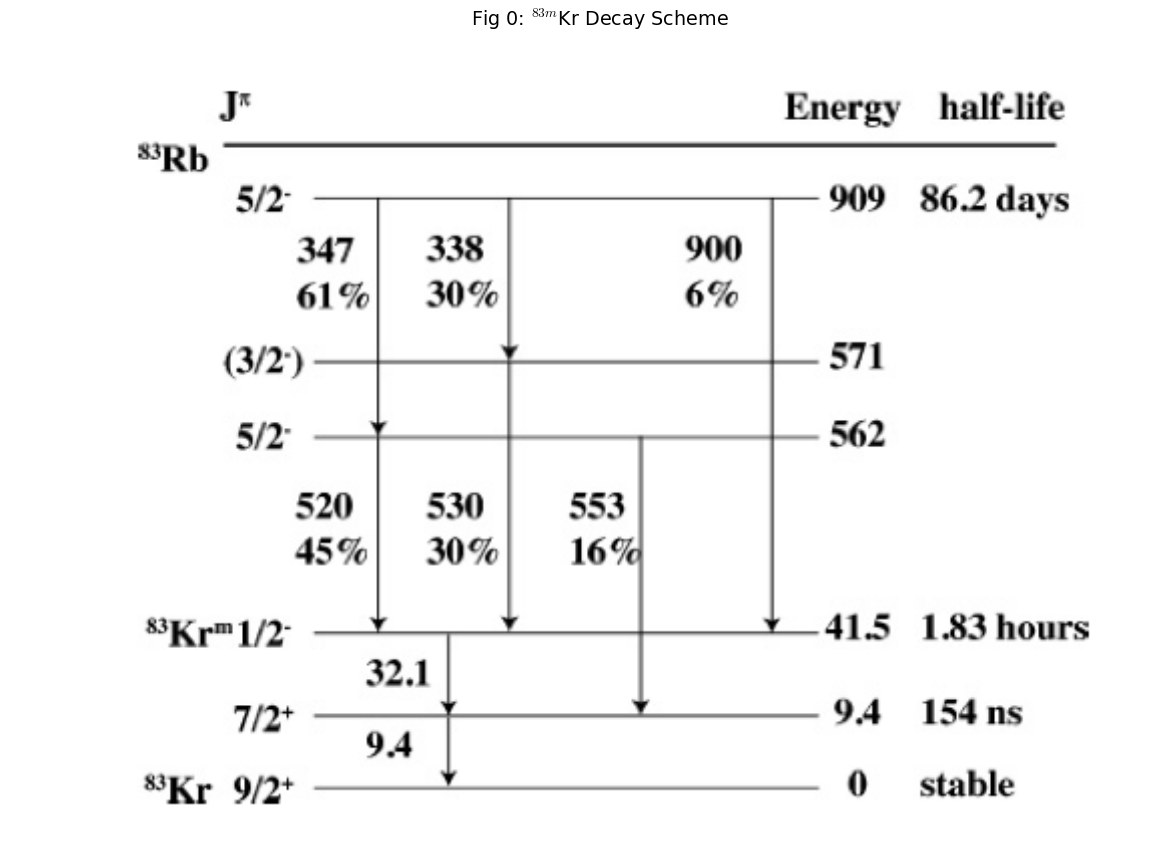

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)  

plt.imshow(mpimg.imread('KrLce_Figures/kr83m_decay_scheme.png'))
plt.title('Fig 0: $^{83m}$Kr Decay Scheme')
plt.axis('off')
plt.show()

The short half-life of $^{83m}Kr$ and its mother permit an internal calibration without introducing unwanted signals into the experiment. Furthermore, the short half-life between the $32.1\ keV$ and $9.4\ keV$ calibration lines provides a unique signal that is essentially background free.

This calibration should provide a uniform distribution of events throughout the detector allowing the analysis of position reconstruction algorithms, non-uniformities in drift field, relative quantum efficiencies of PMTs, light collection efficiency maps, and absolute light yield. Furthermore, the XENON100 detector is capable of measuring the half-life of the $^{83m}Kr_{1/2-}$ and $^{83m}Kr_{7/2+}$ states, though the nuances of time smearing are still under investigation. 

This note focusses on understanding the $^{83m}Kr$ data and generating LCE maps with the intent of building these maps for XENON1T (hopefully very soon!).

<a id='data_and_selection'></a>
# Data and Event Selection

In [4]:
# from 2015 Kr83m diffusion-mode data
datasets_xerawdp = ['xe100_150413_1839','xe100_150414_1535','xe100_150415_1749',
                    'xe100_150416_1832','xe100_150417_1648','xe100_150418_1644',
                    'xe100_150419_0027','xe100_150419_0547','xe100_150419_1611',
                    'xe100_150420_0304','xe100_150420_1809','xe100_150428_1232',
                    'xe100_150429_0515','xe100_150429_2203','xe100_150430_1454',
                    'xe100_150501_0751','xe100_150501_1457','xe100_150502_0802',
                    'xe100_150503_0110','xe100_150503_1826']

# xerawdp path
xerawdpPath = '/project/lgrandi/tunnell/run_14/NewNN/'

# get xerawdp tree, apply event restrictions, and retrieve desirable data
#  see xerawdp_helpers.py for details
xerawdpTree = load_xerawdp_tree(datasets_xerawdp, xerawdpPath)
if 'xerawdp_krRestricted.pkl' not in glob.glob('*'):
    df_xerawdp = build_xerawdp_df(xerawdpTree)
    df_xerawdp.to_pickle('xerawdp_krRestricted.pkl')
else:
    df_xerawdp = pd.read_pickle('xerawdp_krRestricted.pkl')

In [3]:
# datasets processed by pax_4.1.2
datasets_pax = ['xe100_150413_1839','xe100_150414_1535','xe100_150415_1749',
                'xe100_150416_1832','xe100_150419_1611','xe100_150420_0304',
                'xe100_150420_1809']

for i in range(len(datasets_pax)):
    datasets_pax[i]+='_pax4.9.1'

# load minitrees
# throws error when building minitrees for many datasets, I built them one by one

data = hax.minitrees.load(datasets_pax, treemakers=Kr83m_Basic)
df_pax = pd.DataFrame(data[data['s10Time']>=0]) # remove NaNs

Don't know a run named xe100_150413_1839_pax4.9.1, trying to find it anyway...
Don't know a run named xe100_150414_1535_pax4.9.1, trying to find it anyway...
Don't know a run named xe100_150415_1749_pax4.9.1, trying to find it anyway...
Don't know a run named xe100_150416_1832_pax4.9.1, trying to find it anyway...
Don't know a run named xe100_150419_1611_pax4.9.1, trying to find it anyway...
Don't know a run named xe100_150420_0304_pax4.9.1, trying to find it anyway...
Don't know a run named xe100_150420_1809_pax4.9.1, trying to find it anyway...


The xerawdp data is from Luca Scotto's re-processing to remove more noisy PMT's and adjust the NN reconstruction (20 datasets total, see code for details). The pax data is from a partial processing of the $^{83m}Kr$ data and includes 7 datasets (pax v4.9.1, and again see code for dataset details).

Xerawdp Data Path | Pax Data Path
------------------|--------------
/project/lgrandi/tunnell/run_14/NewNN/ | /project/lgrandi/tunnell/run_14/paxProcessed_kr83mDiffusion/
$$ \textbf{Table 1: }\text{Paths to data on midway }$$

Event selection has been broken into 2 parts; processed data is required to meet **restrictions** which guarantee the existence of the information necessary to apply other $^{83m}Kr$ selections, and **selections** which produce the final event selections. The goal is that only the restrictions differ between xerawdp and pax.

In [5]:
# acceptance after restrictions
#print(len(df_xerawdp.values)/xerawdpTree.GetEntries())
print(len(df_pax.values)/len(data.values))

0.33289874101349304


## Event Restrictions

In a perfect $^{83m}Kr$ world we search for two distinct s1-s2 pairs. With xerawdp data this is acomplished by requiring at least 2 s1s and at least 1 s2, while in pax we simply require at least 2 interactions with distinct s1s (assuming interactions[0] is the first valid s1-s2 pair).

Xerawdp Restrictions | Pax Restrictions
---------------------|-----------------
NbS1Peaks >= 2 | len(event.interactions) > 0
S1sTot[0] > 0 | $$\exists \ interaction:interaction.s1 \neq interactions[0].s1$$
NbS1Peaks >= 1 |
$$ \textbf{Table 2: }\text{Xerawdp and Pax Event Restrictions }$$

After these event restrictions the acceptance ratios are $0.6262$ and $0.3329$ for Xerawdp and Pax respectively.



In [5]:
# Add some colums to dataframes for easy cut comparison
for df in [df_xerawdp,df_pax]:
    df['s1Dt'] = df['s11Time']-df['s10Time']
    df['s1Gap'] = df['s11LeftEdge']-df['s10RightEdge']
    df['s20Width'] = df['s20RightEdge']-df['s20LeftEdge']
    df['s1sSpan'] = df['s11RightEdge']-df['s10LeftEdge']
    df['s1s2Deficit'] = df['s20Width']-df['s1sSpan']
    df['s1sRatio'] = df['s11Area']/df['s10Area']

KeyError: 's11Time'

In [ ]:
cuts = [ ['s10Coin',2,'none',50,0,100,'channels'],
         ['s11Coin',2,'none',50,0,100,'channels'],
         ['s20Area',150,'none',50,0,30000,'PE'],
         ['s1Gap',0,'none',50,-5000,5000,'ns'],
         ['s21Area','none',150,50,0,20000,'PE'],
         ['s1s2Deficit',0,'none',50,-5000,5000,'ns'],
         ['s1Dt',500,1000,50,-1000,5000,'ns'],
         ['s1sRatio',0.1,1.0,50,0,1.2,'PE/PE']]

In [ ]:
for cut in cuts:
    cut_compare(df_xerawdp,df_pax,cut)

In [ ]:
print(n1_cuts(df_xerawdp,cuts)/xerawdpTree.GetEntries())
print(n1_cuts(df_pax,cuts)/len(data.values))

## Event Selection

With the restrictions in place we pull the desirable data from xerawdp and pax data, and move forward with event selection treating both processors on an equal footing. The selections considered here are taken from Richard's production of LCE maps for Xerawdp.

Figures 1-7 shows plots of each selection in its own parameter space with the acceptance shown in the figures themselves (0+1 approach). For another interpretation of the performance of these selections we consider the total acceptance ratios with the $n-1$ approach. Table 3 shows the results.

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 18.0)  

plt.imshow(mpimg.imread('KrLce_Figures/f_s10CoinHists.png'))
plt.title('Fig 1: Histogram for $s10Coin\ >=\ 2$')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s11CoinHists.png'))
plt.title('Fig 2: Histogram for $s11Coin\ >=\ 2$')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s20AreaHists.png'))
plt.title('Fig 3: Histogram for $s20Area\ >=\ 150$')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s1GapHists.png'))
plt.title('Fig 4: Histogram for $s1Gap\ =\ s11LeftEdge\ -\ s10RightEdge\ >=\ 0$')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s21AreaHists.png'))
plt.title('Fig 5: Histogram for $s21Area\ <=\ 150$')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s1s2DeficitHists.png'))
plt.title('Fig 6: Histogram for $s1s2Deficit\ =\ (s20RightEdge-s20LeftEdge)\ -\ (s11RightEdge-s10LeftEdge)\ >=\ 0$')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s1DtHists.png'))
plt.title('Fig 7: Histogram for $500\ <=\ s1Dt\ =\ s11Time-s10Time\ <=\ 1000$')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s1sRatioHists.png'))
plt.title('Fig 8: Histogram for $0.1\ <=\ s1sRatio\ =\ s11Area/s10Area\ <=\ 1.0$')
plt.axis('off')
plt.show()

Excluded Selection | Xerawdp Acceptance Ratio | Pax Acceptance Ratio
-------------------|--------------------------|---------------------
none | 0.03722 | 0.05408
s10Coin>=2 | 0.03722 | 0.05408
s11Coin>=2 | 0.03797 | 0.05408
s20Area>=150 | 0.03735 |  0.05410
s1Gap=s11LeftEdge-s10RightEdge>=0 | 0.03736 | 0.05408
s21Area<=150 | 0.03751 | 0.05437
s1s2Deficit=(s20RightEdge-s20LeftEdge)-(s11RightEdge-s10LeftEdge)>=0 | 0.03722 | 0.05408
500<=s1Dt=s11Time-s10Time<=1000 | 0.09620 | 0.2535
0.1<=s1sRatio=s11Area/s10Area<=1.0 | 0.03918 | 0.05493
$$\textbf{Table 3: }\text{Xerawdp and Pax Acceptance Ratios for n-1 Selection Study}$$

In [ ]:
df_xerawdp_cut = apply_cuts(df_xerawdp,cuts)
print(len(df_xerawdp_cut.values))
df_pax_cut = apply_cuts(df_pax,cuts)
print(len(df_pax_cut.values))

In [ ]:
h_xy_xerawdp = ROOT.TH2D('','',50,-16,16,50,-17,17)
h_xy_pax = ROOT.TH2D('','',50,-16,16,50,-17,17)

for i in range(len(df_xerawdp_cut.values)):
    h_xy_xerawdp.Fill(df_xerawdp_cut['i0x'].values[i],df_xerawdp_cut['i0y'].values[i])
    
for i in range(len(df_pax_cut.values)):
    h_xy_pax.Fill(df_pax_cut['i0x'].values[i],df_pax_cut['i0y'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,700)
ROOT.gStyle.SetOptStat(0)
c1.Divide(2,1,0.02,0.02)

p1 = c1.cd(1)
p1.SetLogz()
h_xy_xerawdp.GetXaxis().SetTitle('x (cm)')
h_xy_xerawdp.GetXaxis().CenterTitle()
h_xy_xerawdp.GetYaxis().SetTitle('y (cm)')
h_xy_xerawdp.GetYaxis().CenterTitle()
h_xy_xerawdp.SetTitle('Xerawdp x vs. y Histogram')
h_xy_xerawdp.SetMaximum(3e2)
h_xy_xerawdp.Draw('colz')

p2 = c1.cd(2)
p2.SetLogz()
h_xy_pax.GetXaxis().SetTitle('x (cm)')
h_xy_pax.GetXaxis().CenterTitle()
h_xy_pax.GetYaxis().SetTitle('y (cm)')
h_xy_pax.GetYaxis().CenterTitle()
h_xy_pax.SetTitle('Pax x vs. y Histogram')
h_xy_pax.SetMaximum(3e2)
h_xy_pax.Draw('colz')

c1.Print('./KrLce_Figures/f_xyHists.png')
c1.Clear()

In [ ]:
h_rrz_xerawdp = ROOT.TH2D('','',50,0,280,50,5,-35)
h_rrz_pax = ROOT.TH2D('','',50,0,280,50,5,-35)

for i in range(len(df_xerawdp_cut.values)):
    rr = df_xerawdp_cut['i0x'].values[i]**2+df_xerawdp_cut['i0y'].values[i]**2
    h_rrz_xerawdp.Fill(rr,df_xerawdp_cut['i0z'].values[i])
    
for i in range(len(df_pax_cut.values)):
    rr = df_pax_cut['i0x'].values[i]**2+df_pax_cut['i0y'].values[i]**2
    h_rrz_pax.Fill(rr,df_pax_cut['i0z'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,700)
ROOT.gStyle.SetOptStat(0)
c1.Divide(2,1,0.02,0.02)

p1 = c1.cd(1)
p1.SetLogz()
h_rrz_xerawdp.GetXaxis().SetTitle('r^{2} (cm^{2})')
h_rrz_xerawdp.GetXaxis().CenterTitle()
h_rrz_xerawdp.GetYaxis().SetTitle('z (cm)')
h_rrz_xerawdp.GetYaxis().CenterTitle()
h_rrz_xerawdp.SetTitle('Xerawdp\ r^{2}\ vs.\ z\  Histogram')
h_rrz_xerawdp.SetMaximum(3e2)
h_rrz_xerawdp.Draw('colz')

p2 = c1.cd(2)
p2.SetLogz()
h_rrz_pax.GetXaxis().SetTitle('r^{2} (cm^{2})')
h_rrz_pax.GetXaxis().CenterTitle()
h_rrz_pax.GetYaxis().SetTitle('z (cm)')
h_rrz_pax.GetYaxis().CenterTitle()
h_rrz_pax.SetTitle('Pax\ r^{2}\ vs.\ z\  Histogram')
h_rrz_pax.SetMaximum(3e2)
h_rrz_pax.Draw('colz')

c1.Print('./KrLce_Figures/f_rrzHists.png')
c1.Clear()

In [ ]:
h_z_xerawdp = ROOT.TH1D('','',50,-5,35)
h_z_pax = ROOT.TH1D('','',50,-5,35)

for i in range(len(df_xerawdp_cut.values)):
    h_z_xerawdp.Fill(df_xerawdp_cut['i0z'].values[i])
    
for i in range(len(df_pax_cut.values)):
    h_z_pax.Fill(df_pax_cut['i0z'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,700)
ROOT.gStyle.SetOptStat(0)
c1.Divide(2,1,0.02,0.02)

p1 = c1.cd(1)
p1.SetLogz()
h_z_xerawdp.GetXaxis().SetTitle('z (cm)')
h_z_xerawdp.GetXaxis().CenterTitle()
h_z_xerawdp.SetTitle('Xerawdp z Histogram')
h_z_xerawdp.SetMaximum(6e3)
h_z_xerawdp.Draw()

p2 = c1.cd(2)
p2.SetLogz()
h_z_pax.GetXaxis().SetTitle('z (cm)')
h_z_pax.GetXaxis().CenterTitle()
h_z_pax.SetTitle('Pax z Histogram')
h_z_pax.SetMaximum(6e3)
h_z_pax.Draw()

c1.Print('./KrLce_Figures/f_zHists.png')
c1.Clear()

In [ ]:
h_s1s_xerawdp = ROOT.TH2D('','',50,0,280,50,0,120)
h_s1s_pax = ROOT.TH2D('','',50,0,280,50,0,120)

for i in range(len(df_xerawdp_cut.values)):
    h_s1s_xerawdp.Fill(df_xerawdp_cut['s10Area'].values[i],df_xerawdp_cut['s11Area'].values[i])
    
for i in range(len(df_pax_cut.values)):
    h_s1s_pax.Fill(df_pax_cut['s10Area'].values[i],df_pax_cut['s11Area'].values[i])

In [ ]:
c1 = ROOT.TCanvas('','',1600,700)
ROOT.gStyle.SetOptStat(0)
c1.Divide(2,1,0.02,0.02)

p1 = c1.cd(1)
p1.SetLogz()
h_s1s_xerawdp.GetXaxis().SetTitle('s10Area (PE)')
h_s1s_xerawdp.GetXaxis().CenterTitle()
h_s1s_xerawdp.GetYaxis().SetTitle('s11Area (PE)')
h_s1s_xerawdp.GetYaxis().CenterTitle()
h_s1s_xerawdp.SetTitle('Xerawdp s10Area vs. s11Area Histogram')
h_z_xerawdp.SetMaximum(5e3)
h_s1s_xerawdp.Draw('colz')

p2 = c1.cd(2)
p2.SetLogz()
h_s1s_pax.GetXaxis().SetTitle('s10Area (PE)')
h_s1s_pax.GetXaxis().CenterTitle()
h_s1s_pax.GetYaxis().SetTitle('s11Area (PE)')
h_s1s_pax.GetYaxis().CenterTitle()
h_s1s_pax.SetTitle('Pax s10Area vs. s11Area Histogram')
h_z_pax.SetMaximum(5e3)
h_s1s_pax.Draw('colz')

c1.Print('./KrLce_Figures/f_s1sHists.png')
c1.Clear()

In [ ]:
h_dt_xerawdp = ROOT.TH1D('','',70,400,1100)
h_dt_pax = ROOT.TH1D('','',70,400,1100)

for i in range(len(df_xerawdp_cut.values)):
    h_dt_xerawdp.Fill(df_xerawdp_cut['s1Dt'].values[i])
    
for i in range(len(df_pax_cut.values)):
    h_dt_pax.Fill(df_pax_cut['s1Dt'].values[i])

In [ ]:
def expDec(x,p):
    f = p[2]+p[0]*np.exp(-np.log(2)*x[0]/p[1])
    return f

In [ ]:
fitFun = ROOT.TF1("fitFun",expDec,500,1000,3)
fitFun.SetParameter(0,200000)
fitFun.SetParameter(1,155)
fitFun.SetParameter(2,10)

c1 = ROOT.TCanvas('','',1600,700)
ROOT.gStyle.SetOptStat(0)
c1.Divide(2,1,0.02,0.02)

p1 = c1.cd(1)
p1.SetLogy()
h_dt_xerawdp.GetXaxis().SetTitle('s11Time - s10Time (ns)')
h_dt_xerawdp.GetXaxis().CenterTitle()
h_dt_xerawdp.SetTitle('Xerawdp s1Dt Histogram')
h_dt_xerawdp.SetMaximum(2e4)
h_dt_xerawdp.Draw()
h_dt_xerawdp.Fit("fitFun","","",500,1000)
fit1 = h_dt_xerawdp.GetFunction("fitFun")
chi21 = fit1.GetChisquare()
ndf1 = fit1.GetNDF()
p11 = fit1.GetParameter(1)
e11 = fit1.GetParError(1)
pt1 = ROOT.TPaveText(.58, .68, .88, .88, 'NDC')
pt1.AddText("t_{1/2}=%1.3f"%p11)
pt1.AddText("#sigma=%1.3f"%e11)
pt1.AddText("#chi^{2}/NDF=%1.3f/%i"%(chi21,ndf1))
pt1.Draw()

p2 = c1.cd(2)
p2.SetLogy()
h_dt_pax.GetXaxis().SetTitle('s11Time - s10Time (ns)')
h_dt_pax.GetXaxis().CenterTitle()
h_dt_pax.SetTitle('Pax s1Dt Histogram')
h_dt_pax.SetMaximum(2e4)
h_dt_pax.Draw()
h_dt_pax.Fit("fitFun","","",500,1000)
fit2 = h_dt_pax.GetFunction("fitFun")
chi22 = fit2.GetChisquare()
ndf2 = fit2.GetNDF()
p12 = fit2.GetParameter(1)
e12 = fit2.GetParError(1)
pt2 = ROOT.TPaveText(.58, .68, .88, .88, 'NDC')
pt2.AddText("t_{1/2}=%1.3f"%p12)
pt2.AddText("#sigma=%1.3f"%e12)
pt2.AddText("#chi^{2}/NDF=%1.3f/%i"%(chi22,ndf2))
pt2.Draw()

c1.Print('./KrLce_Figures/f_dtHists.png')
c1.Clear()

## Another Glance at Event Selection

Here we simply consider a few notable plots of this event selection in Xerawdp and Pax. Figures 9 and 10 show the $x\ vs.\ y$ and $r^2\ vs.\ z$ respectively. Figure 11 shows $s10Area\ vs. s11Area$, and Figure 12 shows the $s11Time-s10Time$ histogram with halflife fit.

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)  

plt.imshow(mpimg.imread('KrLce_Figures/f_xyHists.png'))
plt.title('Fig 9: $x\ vs.\ y$ Histograms')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_rrzHists.png'))
plt.title('Fig 10: $r^2\ vs.\ z$ Histograms')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_s1sHists.png'))
plt.title('Fig 11: $s10Area\ vs.\ s11Area$ Histograms')
plt.axis('off')
plt.show()

plt.imshow(mpimg.imread('KrLce_Figures/f_dtHists.png'))
plt.title('Fig 12: $s1Dt$ Histograms')
plt.axis('off')
plt.show()

<a id='lce_maps'></a>
# LCE Maps

In [ ]:
R = 15.25
Z = -30.3
A_r = [R/5, 2*R/5, 3*R/5, 4*R/5, R]
N_phi = [10, 15, 20, 40, 60]
N_z = 10.0
bin_settings = [R,Z,A_r,N_phi,N_z]

In [ ]:
bin_data_s10_xerawdp = xe100_to_lyBins(df_xerawdp_cut,bin_settings,'s10',bin_spec_dir='Bin_Hists_s10_xerawdp') # for Xerawdp
lyBins_to_txt(bin_data_s10_xerawdp,'s1xyzmap-s10-20160615-xerawdp.txt')

bin_data_s10_pax = xe100_to_lyBins(df_pax_cut,bin_settings,'s10',bin_spec_dir='Bin_Hists_s10_pax') # for Pax
lyBins_to_txt(bin_data_s10_pax,'s1xyzmap-s10-20160615-pax.txt')

difference_in_ly('s1xyzmap-s10-20160615-xerawdp.txt','s1xyzmap-s10-20160615-pax.txt','lceDifference_s10.txt')
triple_plot('s1xyzmap-s10-20160615-xerawdp.txt','s1xyzmap-s10-20160615-pax.txt','lceDifference_s10.txt', 's10',bin_settings,'./KrLce_Figures/f_lceMap_s10.png')

In [ ]:
bin_data_s11_xerawdp = xe100_to_lyBins(df_xerawdp_cut,bin_settings,'s11',bin_spec_dir='Bin_Hists_s11_xerawdp') # for Xerawdp
lyBins_to_txt(bin_data_s11_xerawdp,'s1xyzmap-s11-20160615-xerawdp.txt')

bin_data_s11_pax = xe100_to_lyBins(df_pax_cut,bin_settings,'s11',bin_spec_dir='Bin_Hists_s11_pax') # for Pax
lyBins_to_txt(bin_data_s11_pax,'s1xyzmap-s11-20160615-pax.txt')

difference_in_ly('s1xyzmap-s11-20160615-xerawdp.txt','s1xyzmap-s11-20160615-pax.txt','lceDifference_s11.txt')
triple_plot('s1xyzmap-s11-20160615-xerawdp.txt','s1xyzmap-s11-20160615-pax.txt','lceDifference_s11.txt', 's11',bin_settings,'./KrLce_Figures/f_lceMap_s11.png')

We begin with the same binning originally used by Cecilia for the $^{137}Cs$ LCE maps and again by Richard for the $^{83m}Kr$ LCE maps in Xerawdp. For each of these bins, we pull the mean S1 area from a Gaussian fitted to data. Figure 13 shows some examples of the S1 spectra that are used to extract LY values.

In [ ]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.imshow(mpimg.imread('Bin_Hists_s11_xerawdp/f_s11_z0_r0_phi5.png'))
plt.title('Fig 13a: Xerawdp S11 Spectra for a Single Top Bin')
plt.axis('off')
b = fig.add_subplot(1,2,2)
plt.imshow(mpimg.imread('Bin_Hists_s11_pax/f_s11_z0_r0_phi5.png'))
plt.title('Fig 13b: Pax S11 Spectra for a Single Top Bin')
plt.axis('off')
plt.show()

fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.imshow(mpimg.imread('Bin_Hists_s11_xerawdp/f_s11_z5_r4_phi29.png'))
plt.title('Fig 14a: Xerawdp S11 Spectra for a Single Middle Bin')
plt.axis('off')
b = fig.add_subplot(1,2,2)
plt.imshow(mpimg.imread('Bin_Hists_s11_pax/f_s11_z5_r4_phi29.png'))
plt.title('Fig 14b: Pax S11 Spectra for a Single Middle Bin')
plt.axis('off')
plt.show()

fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.imshow(mpimg.imread('Bin_Hists_s11_xerawdp/f_s11_z9_r2_phi5.png'))
plt.title('Fig 15b: Xerawdp S11 Spectra for a Single Bottom Bin')
plt.axis('off')
b = fig.add_subplot(1,2,2)
plt.imshow(mpimg.imread('Bin_Hists_s11_pax/f_s11_z9_r2_phi5.png'))
plt.title('Fig 15b: Pax S11 Spectra for a Single Bottom Bin')
plt.axis('off')
plt.show()

From here we are able to produce the LCE maps for the data processed by Xerawdp and Pax. Figure 14 and 15 show these LCE maps together with the absolute value of their differences for the $32\ keV$ and $9\ keV$ signals respectively. Note: the positions used to determine the appropriate bin are pulled from the first s2/interaction regardless of whether we consider the $32\ keV$ or $9\ keV$ signal.

<img src="f_lceMap_s10.png">
$$\textbf{Figure 14: }\text{LCE Maps for the }32\ keV\text{ signal of }^{83m}Kr$$  

<img src="f_lceMap_s11.png">
$$\textbf{Figure 15: }\text{LCE Maps for the }9\ keV\text{ signal of }^{83m}Kr$$  

<a id='next_steps'></a>
# Next Steps: Xenon1T

<a id='references'></a>
# References

[[1] S. -C. Wu, Nuclear Data Sheets 92, 893 (2001)](nucleardatasheets_a83.pdf)  